In [1]:
# must go first 
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium

# system packages 
import os, sys
import warnings
warnings.filterwarnings('ignore')

# basic wrangling 
import numpy as np
import pandas as pd

# eda tools 
import pivottablejs
import missingno as msno
import pandas_profiling

# interactive 
import ipywidgets as widgets

# more technical eda
import sklearn
import scipy

In [2]:
sys.path.append('../../scripts/')

from aqua_helper import *

In [3]:
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':16,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

# 评估每个变量与目标之间的关系

## 二维绘图

CATEGORICAL X CATEGORICAL
* [Heat map of contingency table](http://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) 
* [Multiple bar plots](http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot#bar-plots) 

CATEGORICAL X CONTINUOUS 
* [Box plots](http://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot) of continuous for each category
* [Violin plots](http://seaborn.pydata.org/examples/simple_violinplots.html) of continuous distribution for each category
* Overlaid [histograms](http://seaborn.pydata.org/tutorial/distributions.html#histograms) (if 3 or less categories)

CONTINUOUS X CONTINOUS 
* [Scatter plots](http://seaborn.pydata.org/examples/marginal_ticks.html?highlight=scatter) 
* [Hexibin plots](http://seaborn.pydata.org/tutorial/distributions.html#hexbin-plots)
* [Joint kernel density estimation plots](http://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation)
* [Correlation matrix heatmap](http://seaborn.pydata.org/examples/network_correlations.html?highlight=correlation)

In [4]:
data = pd.read_csv('./data/aquastat/aquastat.csv.gzip', compression='gzip')

# simplify regions
data.region = data.region.apply(lambda x: simple_regions[x])

# remove exploitable fields and national rainfall index
data = data.loc[~data.variable.str.contains('exploitable'),:]
data = data.loc[~(data.variable=='national_rainfall_index')]

# Uncomment to print out variable names and explanations
# data[['variable','variable_full']].drop_duplicates()

# Subset for cross-sectional analysis
recent = time_slice(data, '2013-2017')

# Target: GDP per capita

All of our variables are continuous so this will be a CONTINUOUS X CONTINUOUS analysis. 

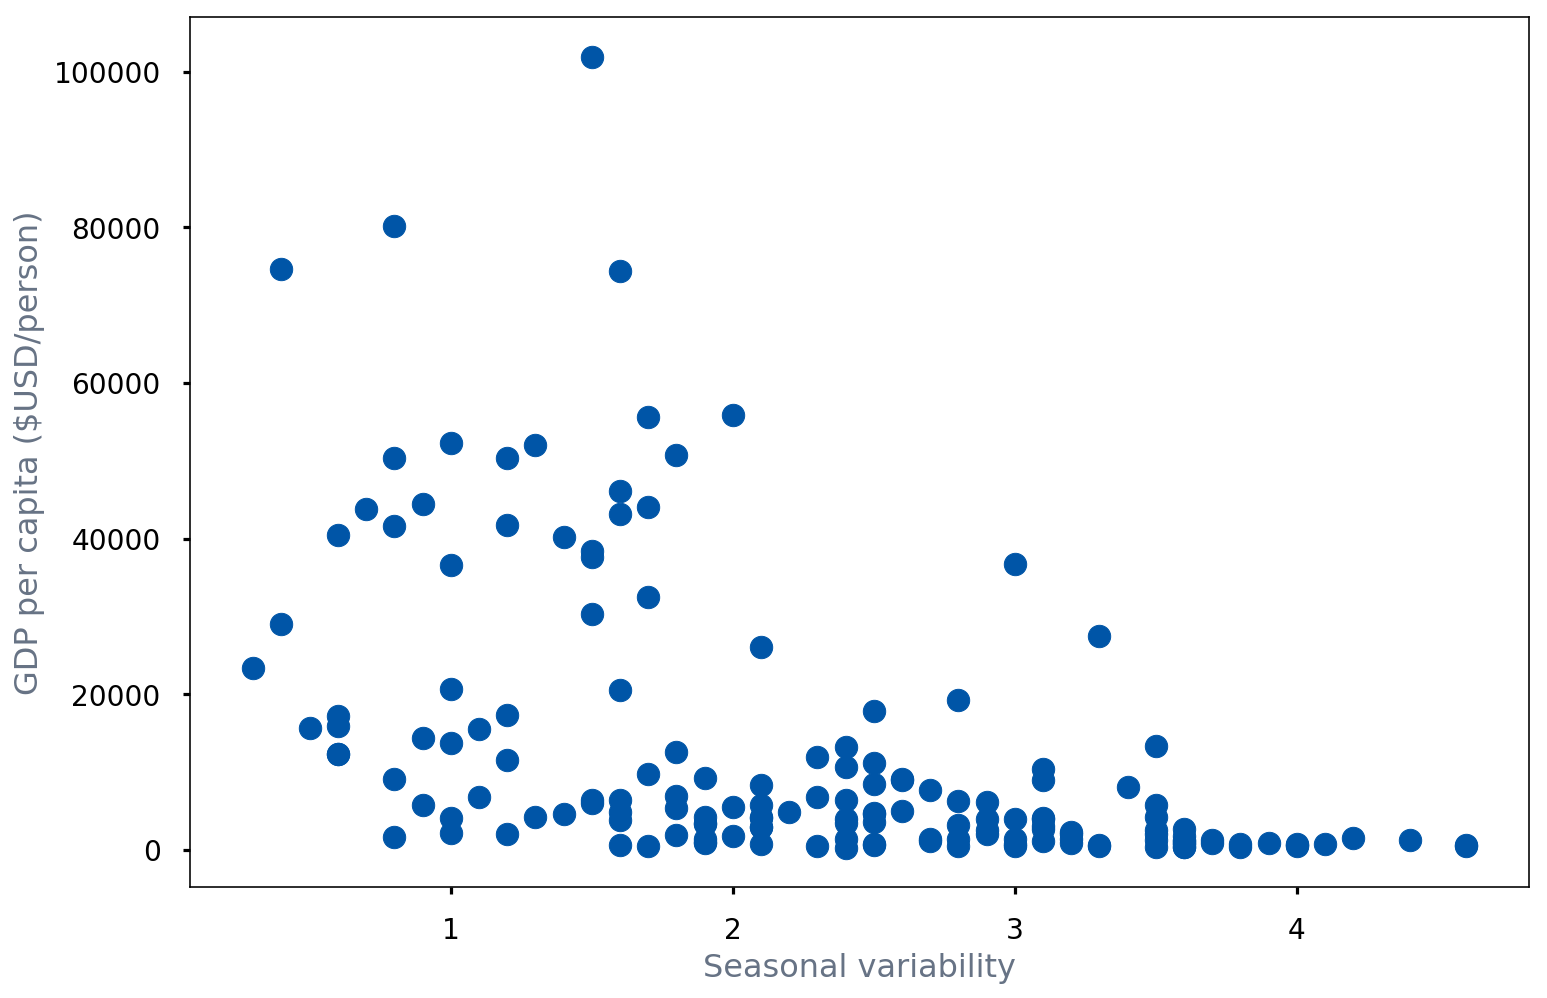

In [5]:
#seasonal_variability 季节变化（WRI）
# recent.drop('gdp_bin', axis=1).astype(float).plot(x='seasonal_variability',y='gdp_per_capita', kind='scatter');
plt.scatter(recent.seasonal_variability, recent.gdp_per_capita)
plt.xlabel('Seasonal variability');
plt.ylabel('GDP per capita ($USD/person)');

In [6]:
def plot_scatter(df, x, y, xlabel=None, ylabel=None, title=None,
                 logx=False, logy=False, by=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 10))

    colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
    if by:
        groups = df.groupby(by)
        for j, (name, group) in enumerate(groups):
            ax.scatter(group[x], group[y], color=colors[j], label=name)
        ax.legend()
    else:
        ax.scatter(df[x], df[y], color=colors[0])
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')

    ax.set_xlabel(xlabel if xlabel else x);
    ax.set_ylabel(ylabel if ylabel else y);
    if title:
        ax.set_title(title);
    return ax

## Joint plot

Now we might also want to understand the relationship between the two variables *and* the distribution of each individually. For this we can use the joint plot from seaborn. 

In [7]:
svr = [recent.seasonal_variability.min(), recent.seasonal_variability.max()]
gdpr = [(recent.gdp_per_capita.min()), recent.gdp_per_capita.max()] 
gdpbins = np.logspace(*np.log10(gdpr), 25)

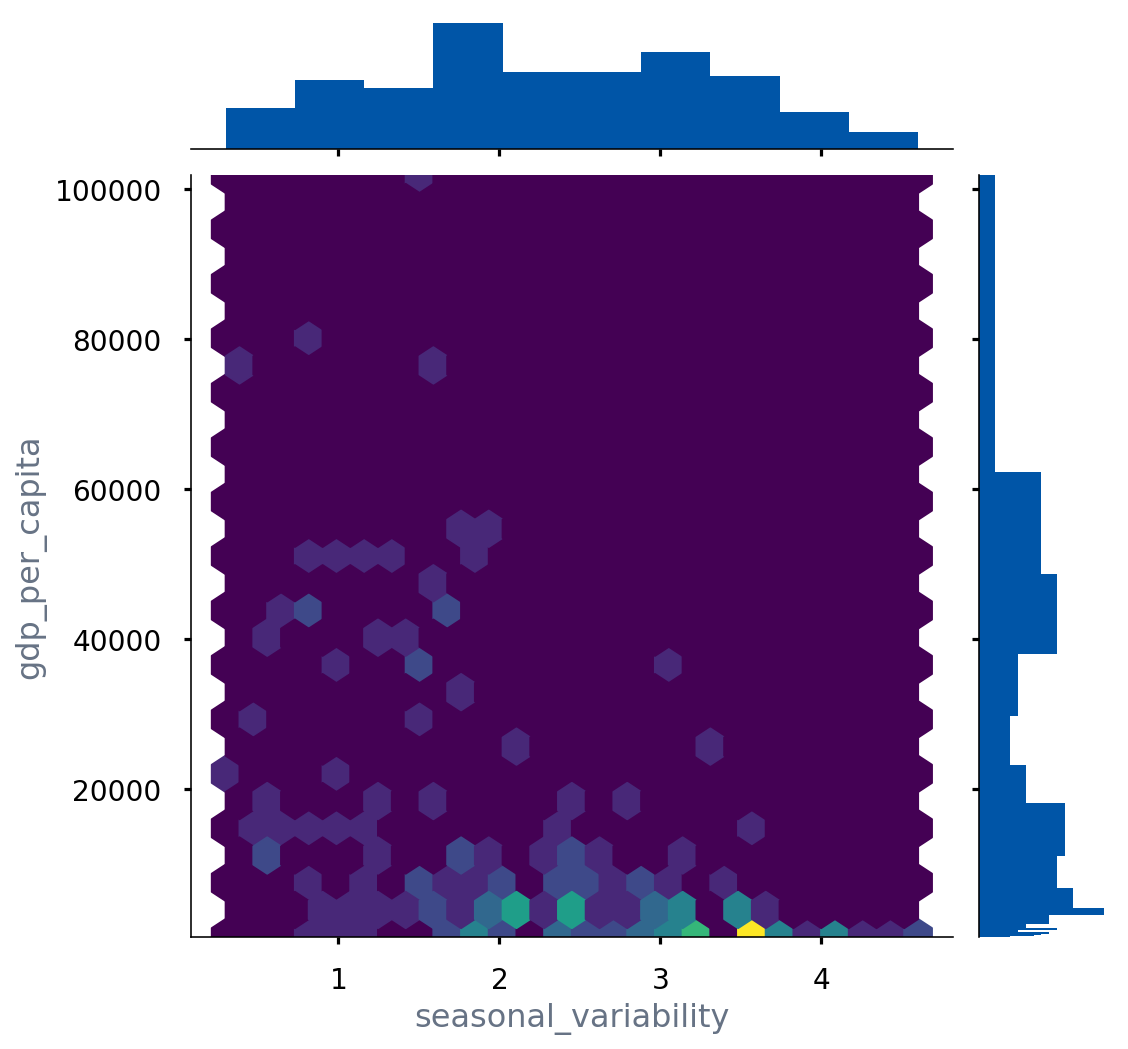

In [8]:
g =sns.JointGrid(x="seasonal_variability", y="gdp_per_capita", data=recent, ylim=gdpr)
g.ax_marg_x.hist(recent.seasonal_variability, range=svr)
g.ax_marg_y.hist(recent.gdp_per_capita, range=gdpr, bins=gdpbins, orientation="horizontal")
g.plot_joint(plt.hexbin, gridsize=25)
ax = g.ax_joint
# ax.set_yscale('log')
g.fig.set_figheight(8)
g.fig.set_figwidth(9)

## Correlation

相关度量两个变量之间的*线性关系的强度。我们可以使用相关性来识别变量。

For linear, `gdp~variable`: 

In [9]:
recent_corr = recent.corr().loc['gdp_per_capita'].drop(['gdp','gdp_per_capita'])

In [10]:
def conditional_bar(series, bar_colors=None, color_labels=None, figsize=(13,24),
                   xlabel=None, by=None, ylabel=None, title=None):
    fig, ax  = plt.subplots(figsize=figsize)
    if not bar_colors:
        bar_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
    plt.barh(range(len(series)),series.values, color=bar_colors)
    plt.xlabel('' if not xlabel else xlabel);
    plt.ylabel('' if not ylabel else ylabel)
    plt.yticks(range(len(series)), series.index.tolist())
    plt.title('' if not title else title);
    plt.ylim([-1,len(series)]);
    if color_labels:
        for col, lab in color_labels.items():
            plt.plot([], linestyle='',marker='s',c=col, label= lab);
        lines, labels = ax.get_legend_handles_labels();
        ax.legend(lines[-len(color_labels.keys()):], labels[-len(color_labels.keys()):], loc='upper right');
    plt.close()
    return fig

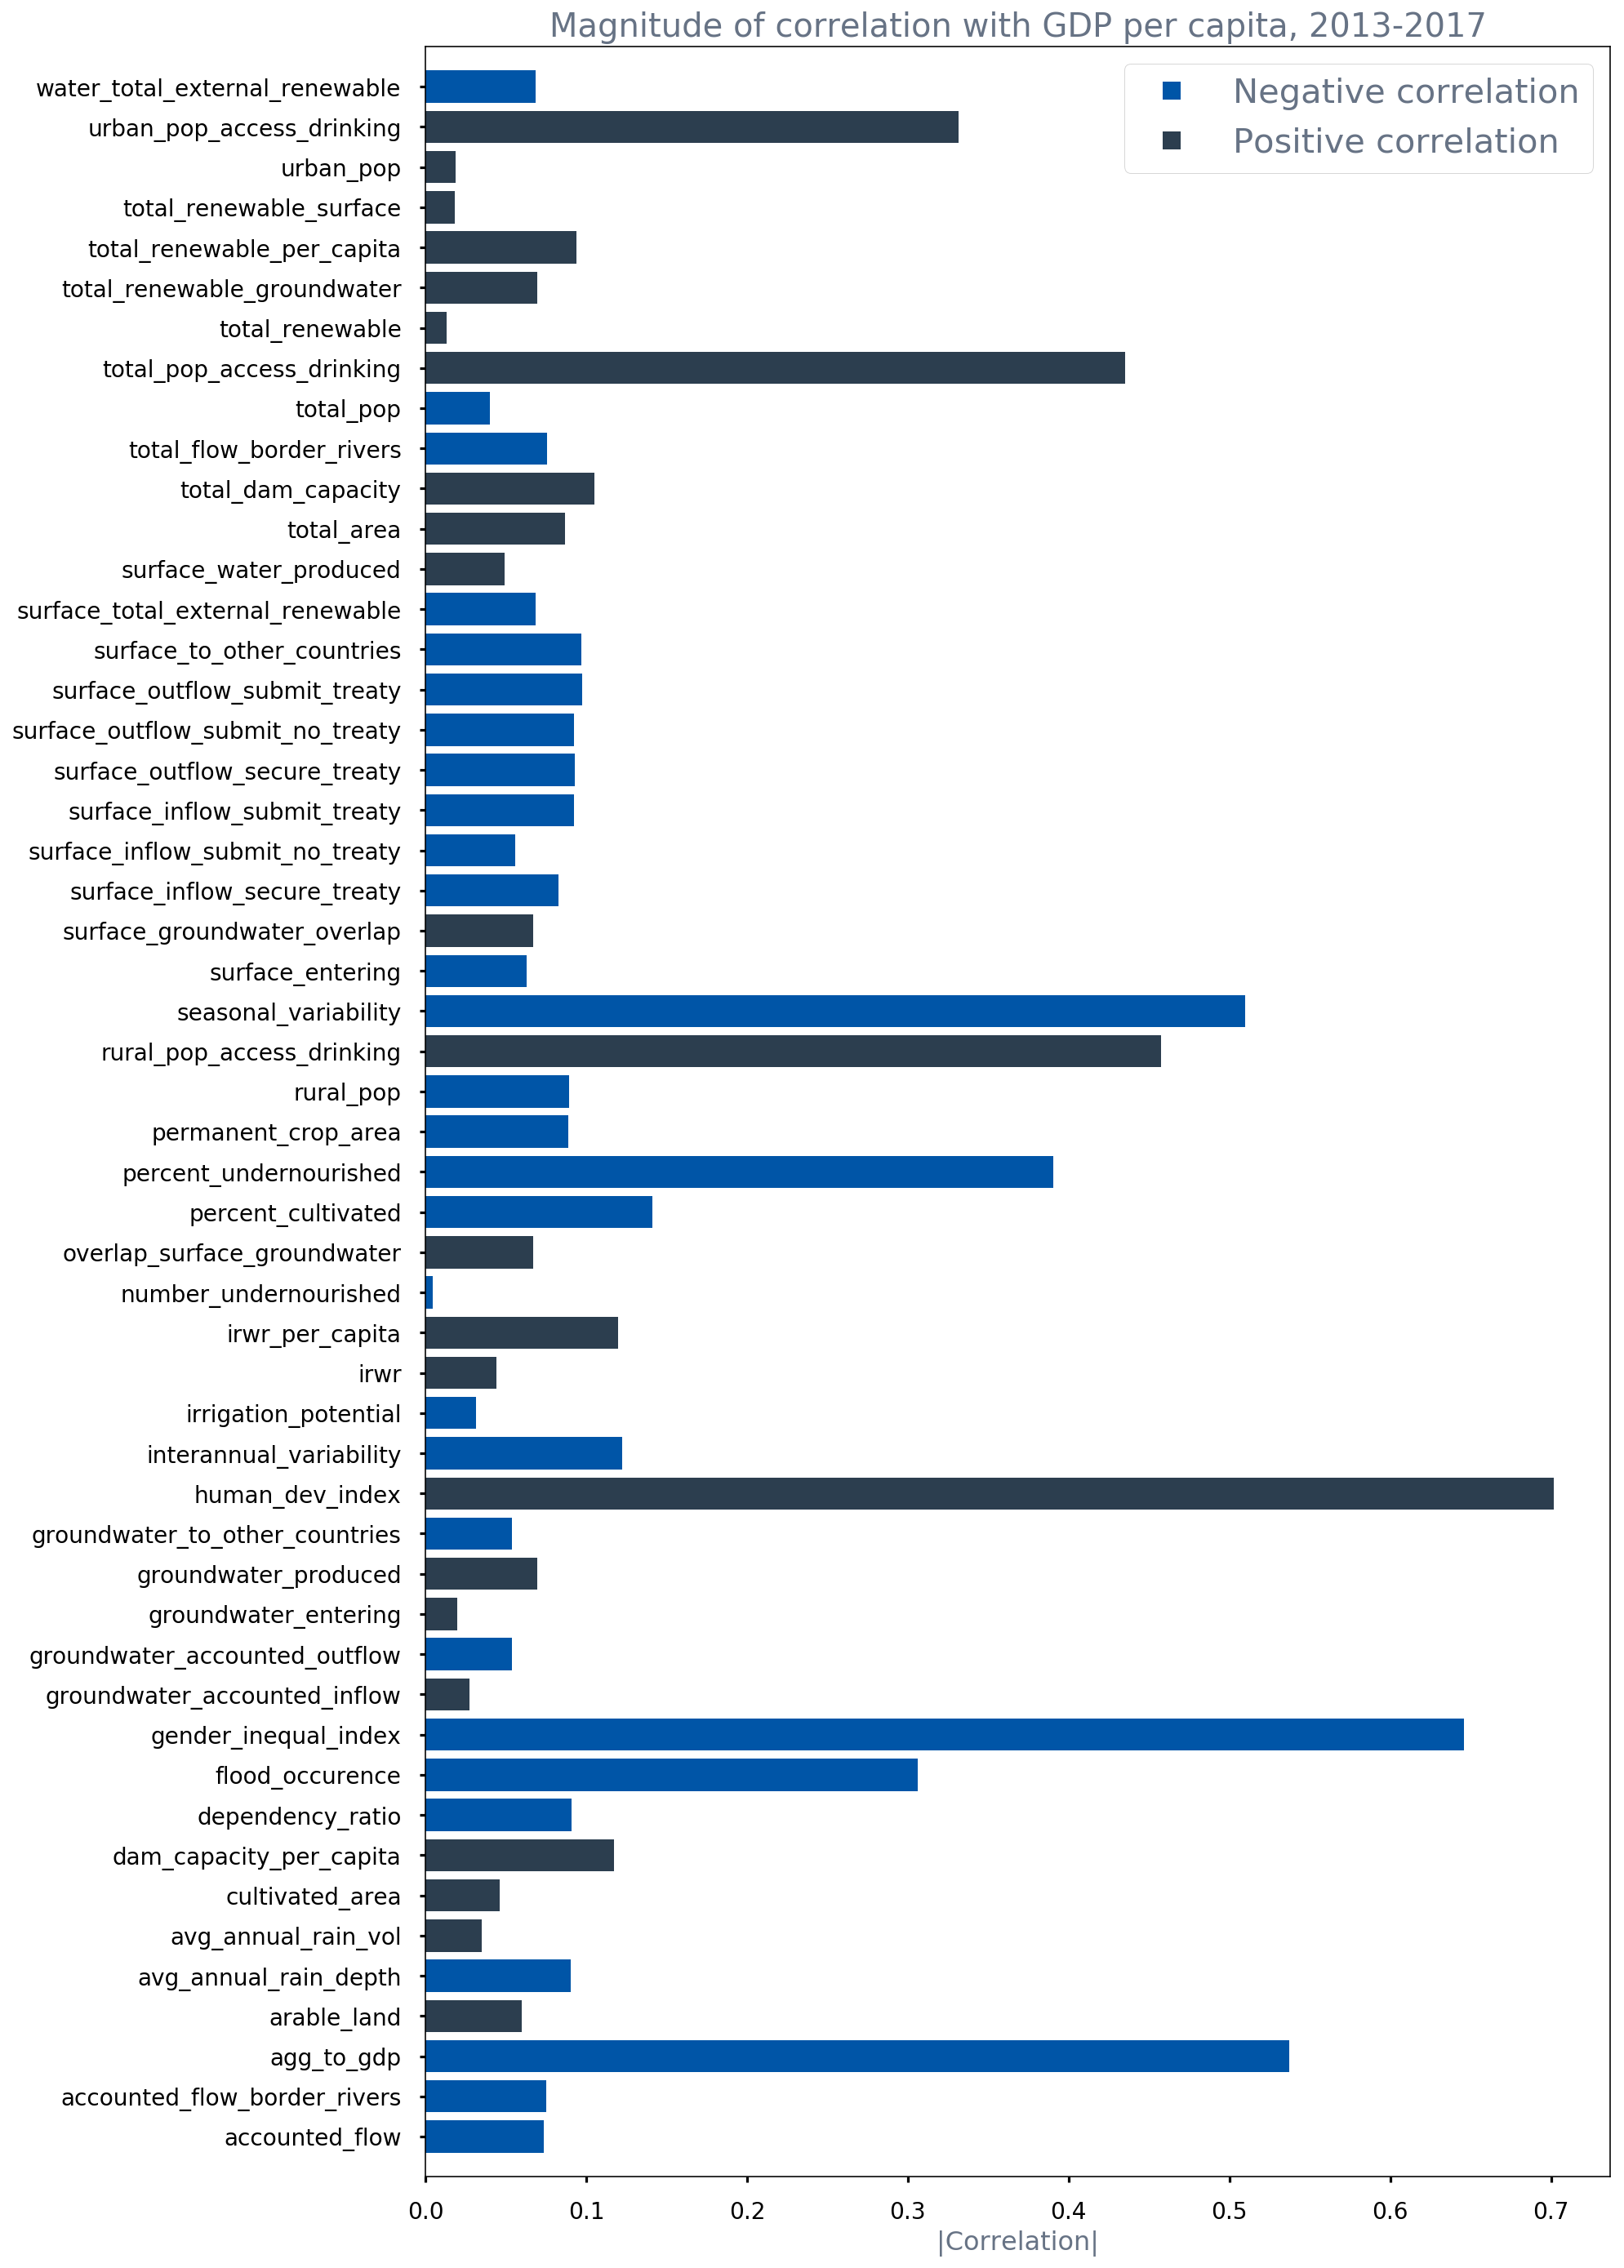

In [11]:
bar_colors = ['#0055A7' if x else '#2C3E4F' for x in list(recent_corr.values < 0)]
color_labels = {'#0055A7':'Negative correlation', '#2C3E4F':'Positive correlation'}

conditional_bar(recent_corr.apply(np.abs), bar_colors, color_labels,
               title='Magnitude of correlation with GDP per capita, 2013-2017',
               xlabel='|Correlation|')

# Target: GDP per capita, binned


While correlation is useful for assessing  relationships, it is limited to only *linear* relationships. As we have seen though, there seem to be many non-linear relationships. We could assess correlation for log transformed variables (see the extras below), but we still may have non-linear relationships. One way to address this is to bin variables into categories and look at the distribution of other variables for each category. 

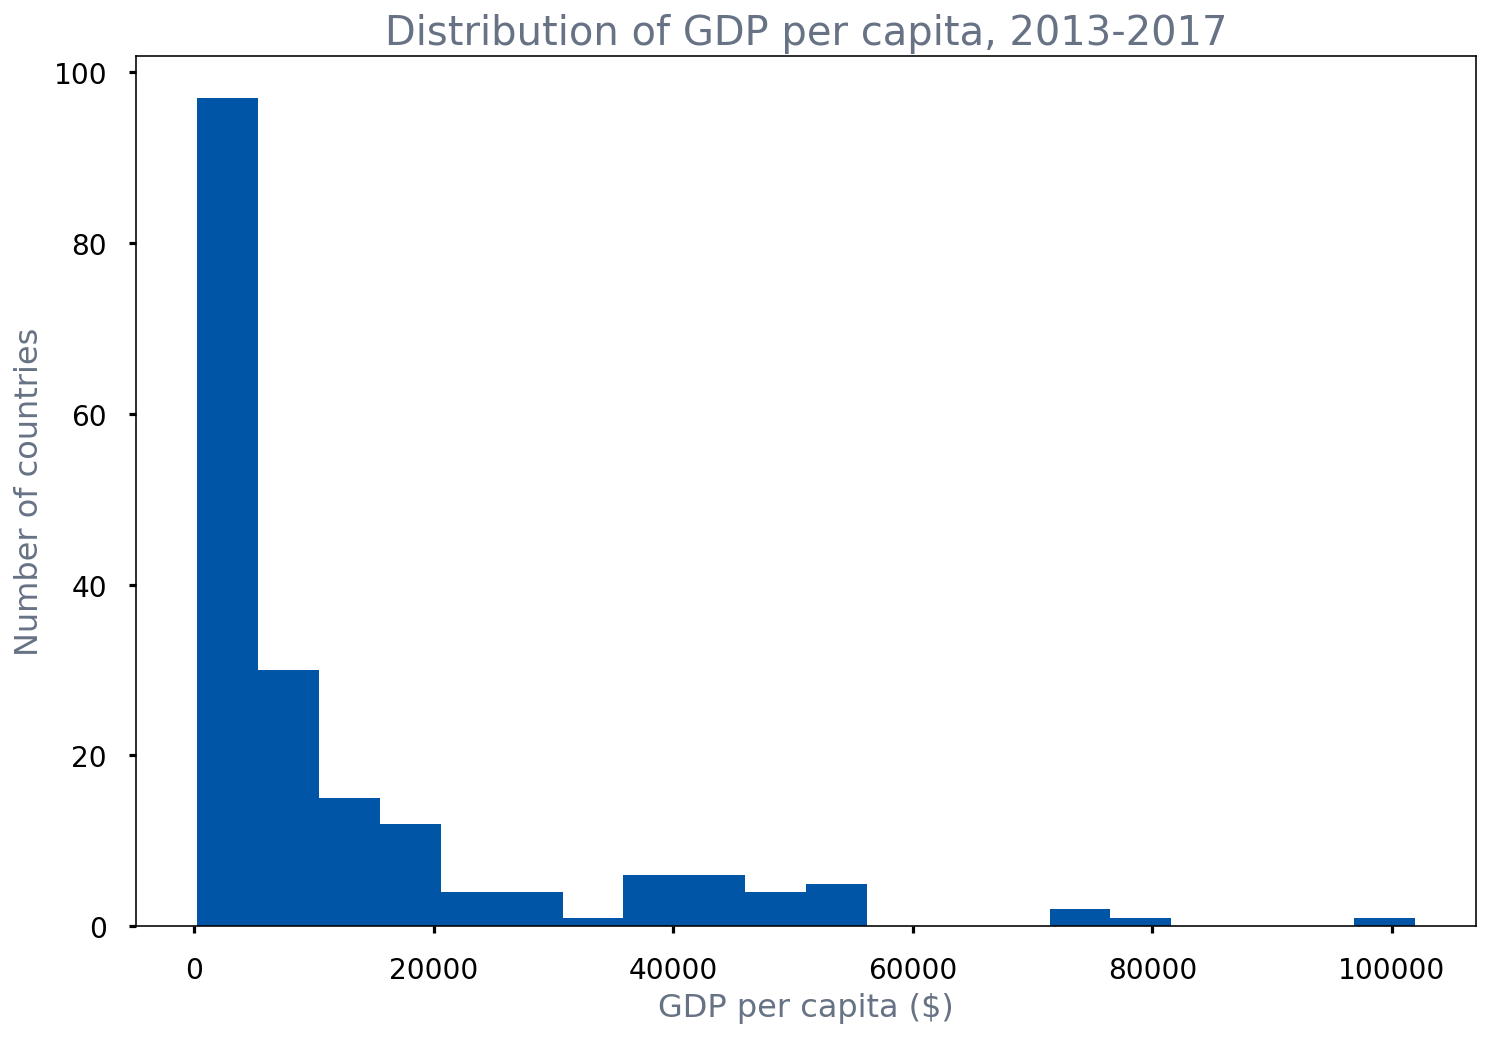

In [12]:
plot_hist(recent, 'gdp_per_capita', xlabel='GDP per capita ($)', 
         ylabel='Number of countries', 
          title='Distribution of GDP per capita, 2013-2017');

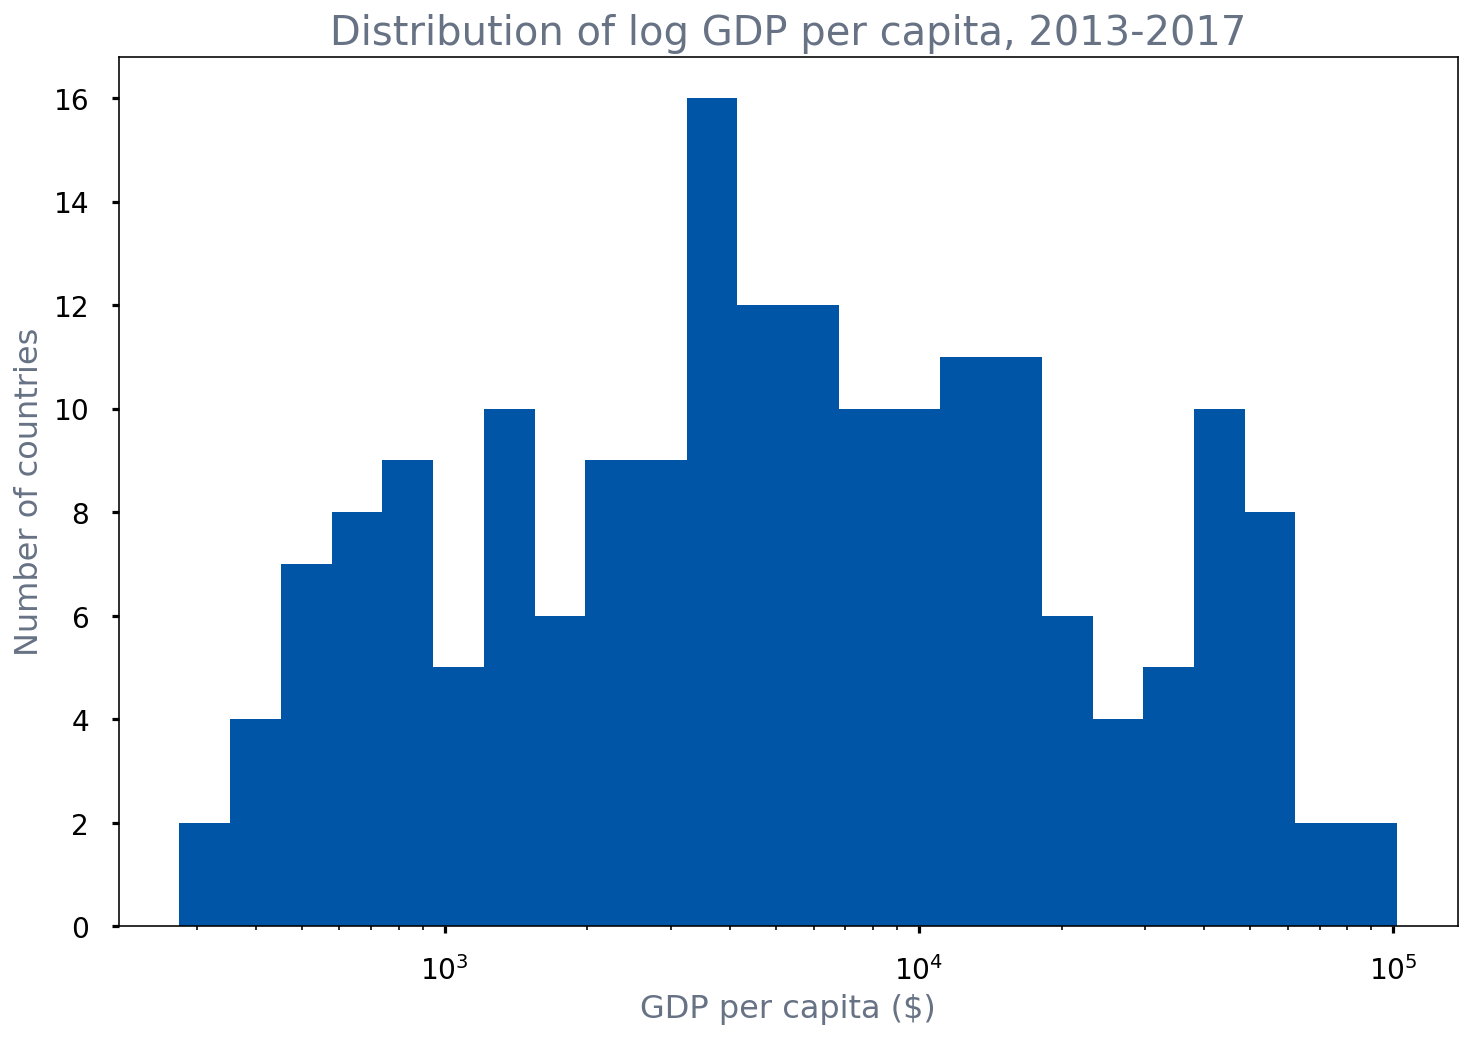

In [13]:
plot_hist(recent, 'gdp_per_capita', xlabel='GDP per capita ($)', logx=True, 
         ylabel='Number of countries', bins=25,
          title='Distribution of log GDP per capita, 2013-2017');

Let's look at `gdp_per_capita` binned into quintiles. 

In [14]:
capita_bins = ['Very low', 'Low', 'Medium', 'High', 'Very high']
recent['gdp_bin'] = pd.qcut(recent.gdp_per_capita, 5, capita_bins)
bin_ranges = pd.qcut(recent.gdp_per_capita, 5).unique()

Let's take our histogram function from before and add in the ability to color by category. 

In [15]:
def plot_hist(df, variable, bins=None, xlabel=None, by=None,
              ylabel=None, title=None, logx=False, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))
    if logx:
        bins = np.logspace(np.log10(df[variable].min()),
                           np.log10(df[variable].max()), bins)
        ax.set_xscale("log")

    if by:
        if type(df[by].unique()) == pd.core.categorical.Categorical:
            cats = df[by].unique().categories.tolist()
        else:
            cats = df[by].unique().tolist()

        for cat in cats:
            to_plot = df[df[by] == cat][variable].dropna()
            ax.hist(to_plot, bins=bins);
    else:
        ax.hist(df[variable].dropna().values, bins=bins);

    if xlabel:
        ax.set_xlabel(xlabel);
    if ylabel:
        ax.set_ylabel(ylabel);
    if title:
        ax.set_title(title);

    return ax

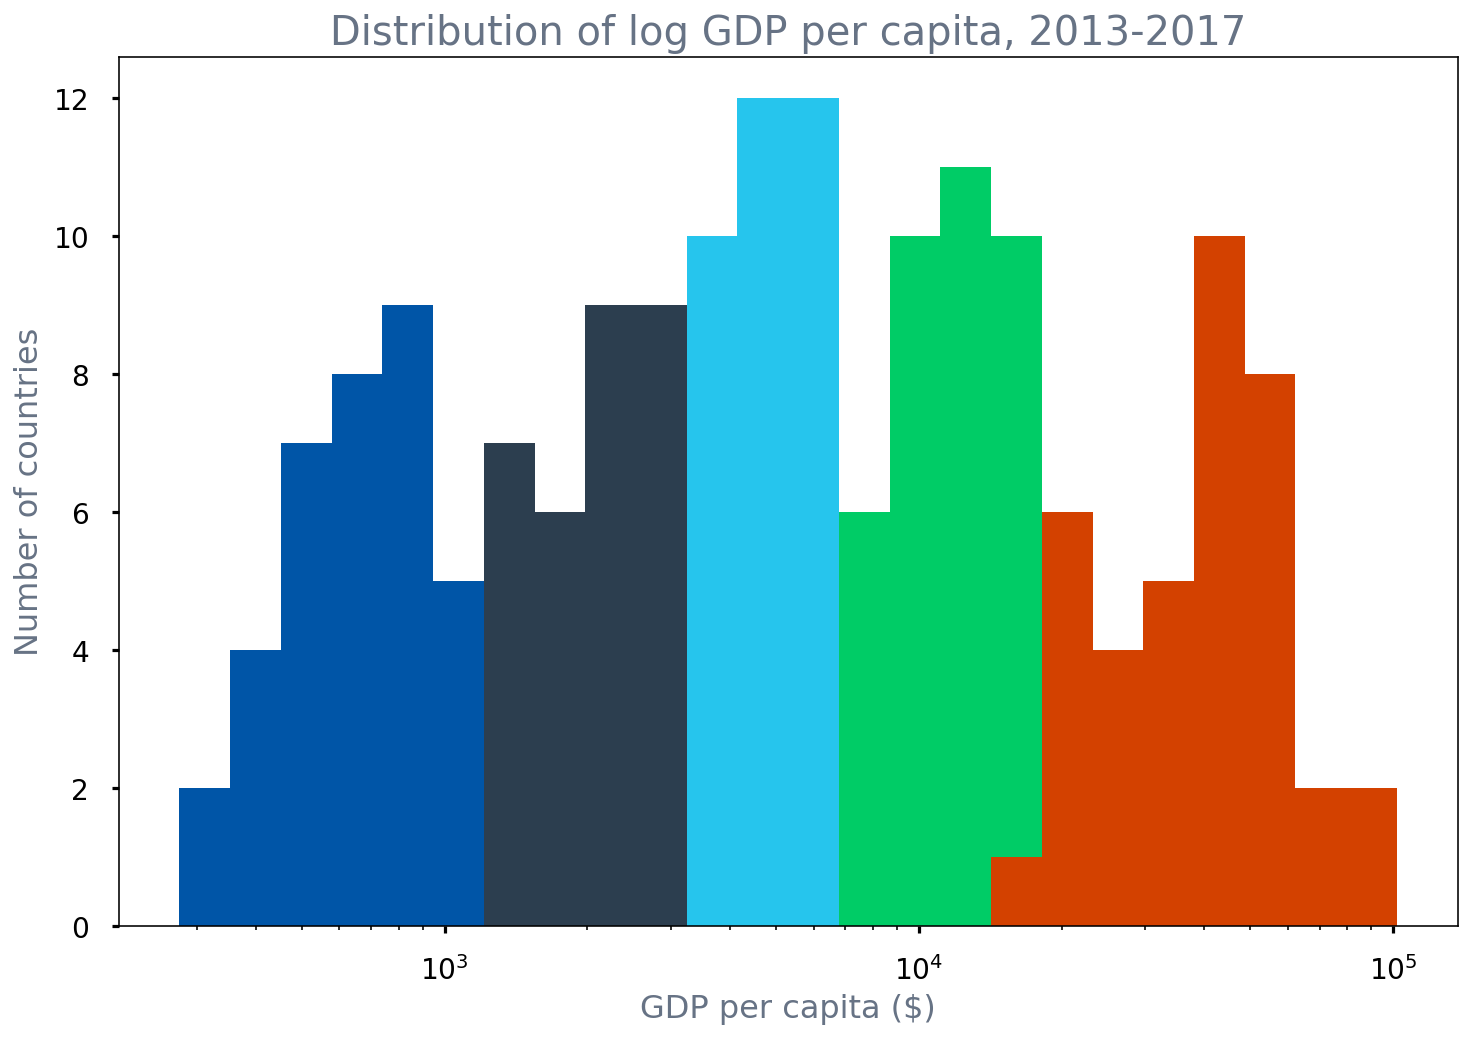

In [16]:
plot_hist(recent, 'gdp_per_capita', xlabel='GDP per capita ($)', logx=True, 
         ylabel='Number of countries', bins=25, by='gdp_bin',
          title='Distribution of log GDP per capita, 2013-2017')

Now we have a CATEGORICAL X CONTINUOUS analysis. Let's look at the distribution of a few variables for each gdp group. 

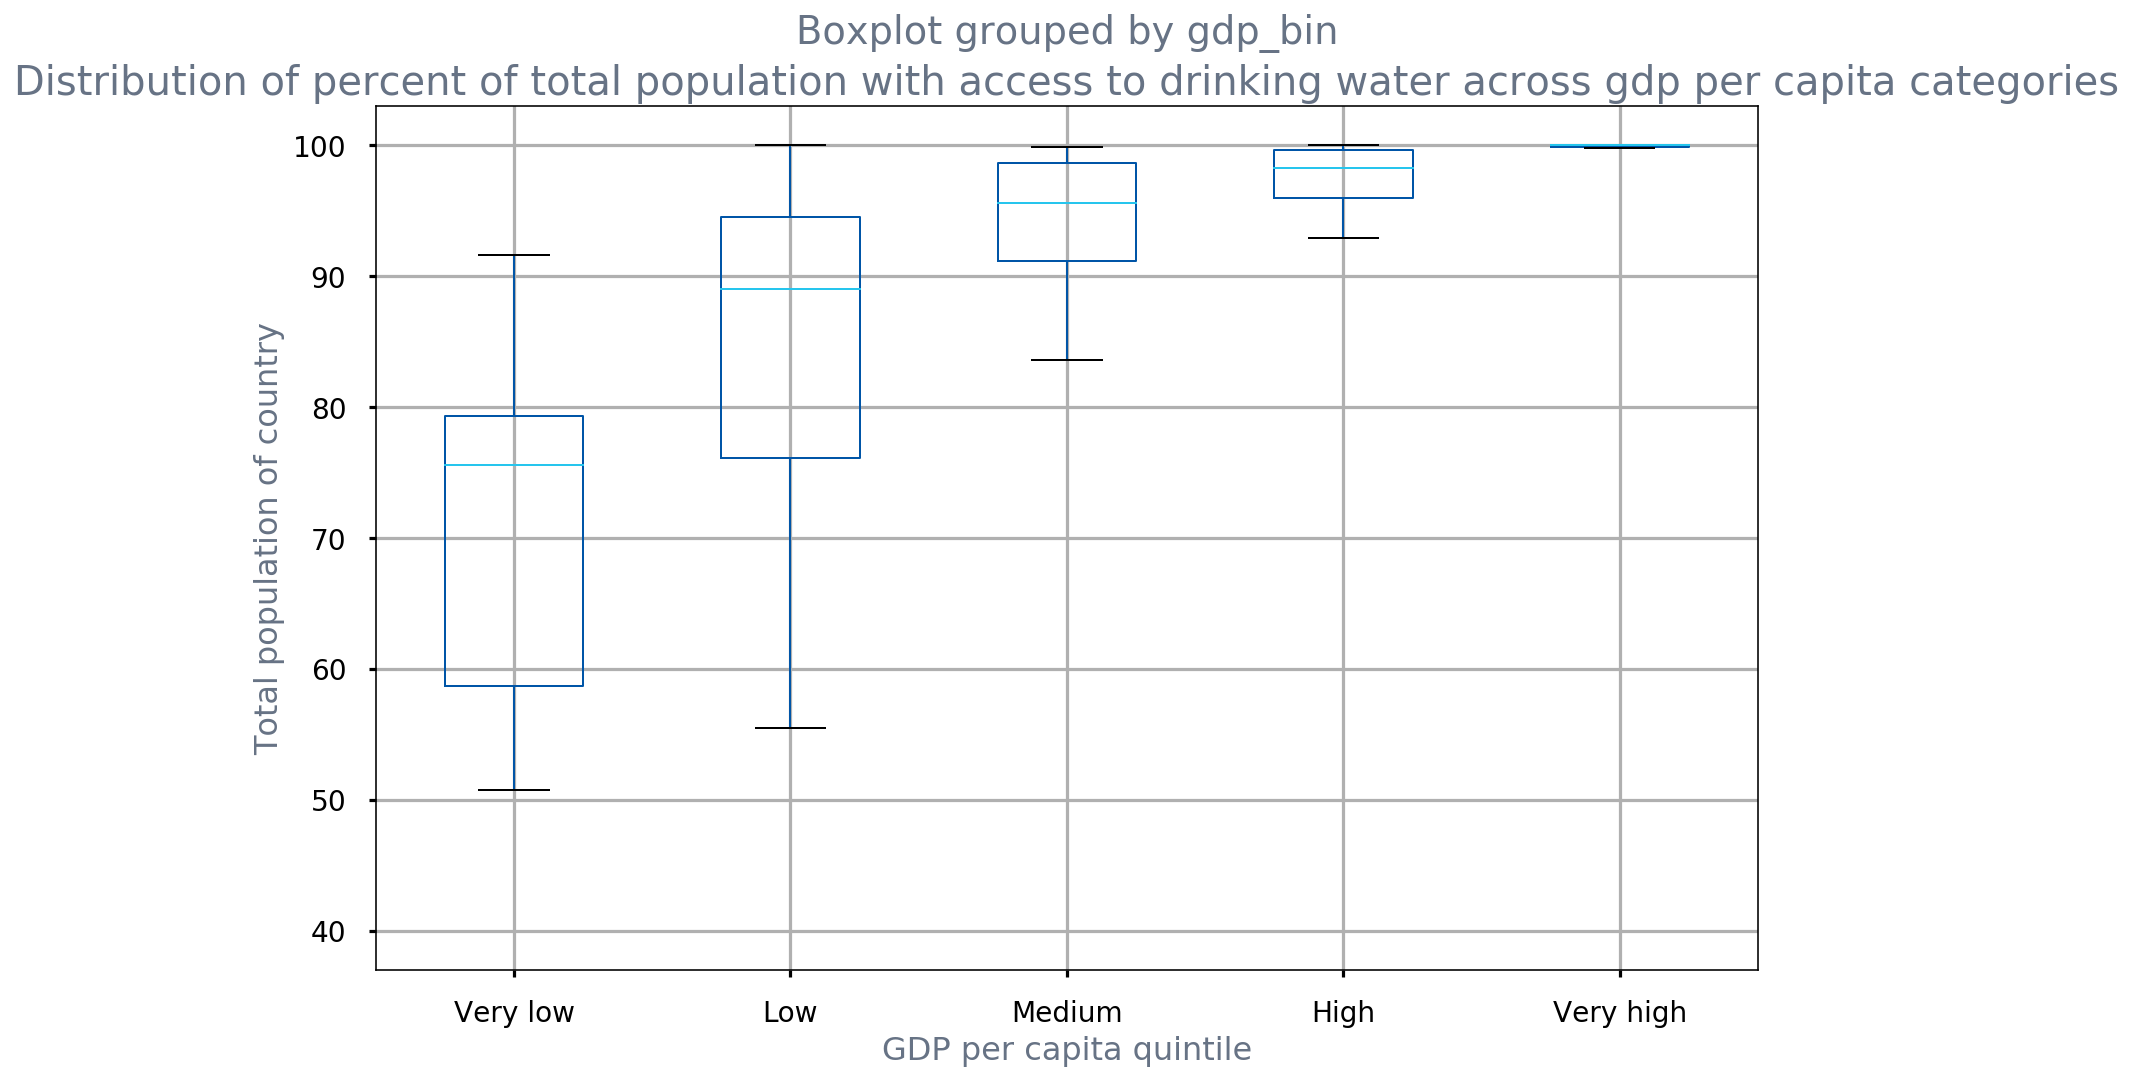

In [17]:
recent[['gdp_bin','total_pop_access_drinking']].boxplot(by='gdp_bin');
# plt.ylim([0,100000]);
plt.title('Distribution of percent of total population with access to drinking water across gdp per capita categories');
plt.xlabel('GDP per capita quintile');
plt.ylabel('Total population of country');

In [18]:
def mult_boxplots(df, variable, category, 
                  xlabel=None, ylabel=None, title=None,
                  ylim=None):
    df[[variable, category]].boxplot(by=category);
    
    if xlabel:
        plt.xlabel(xlabel);
    if ylabel:
        plt.ylabel(ylabel);
    if title:
        plt.title(title);
    if ylim:
        plt.ylim(ylim);

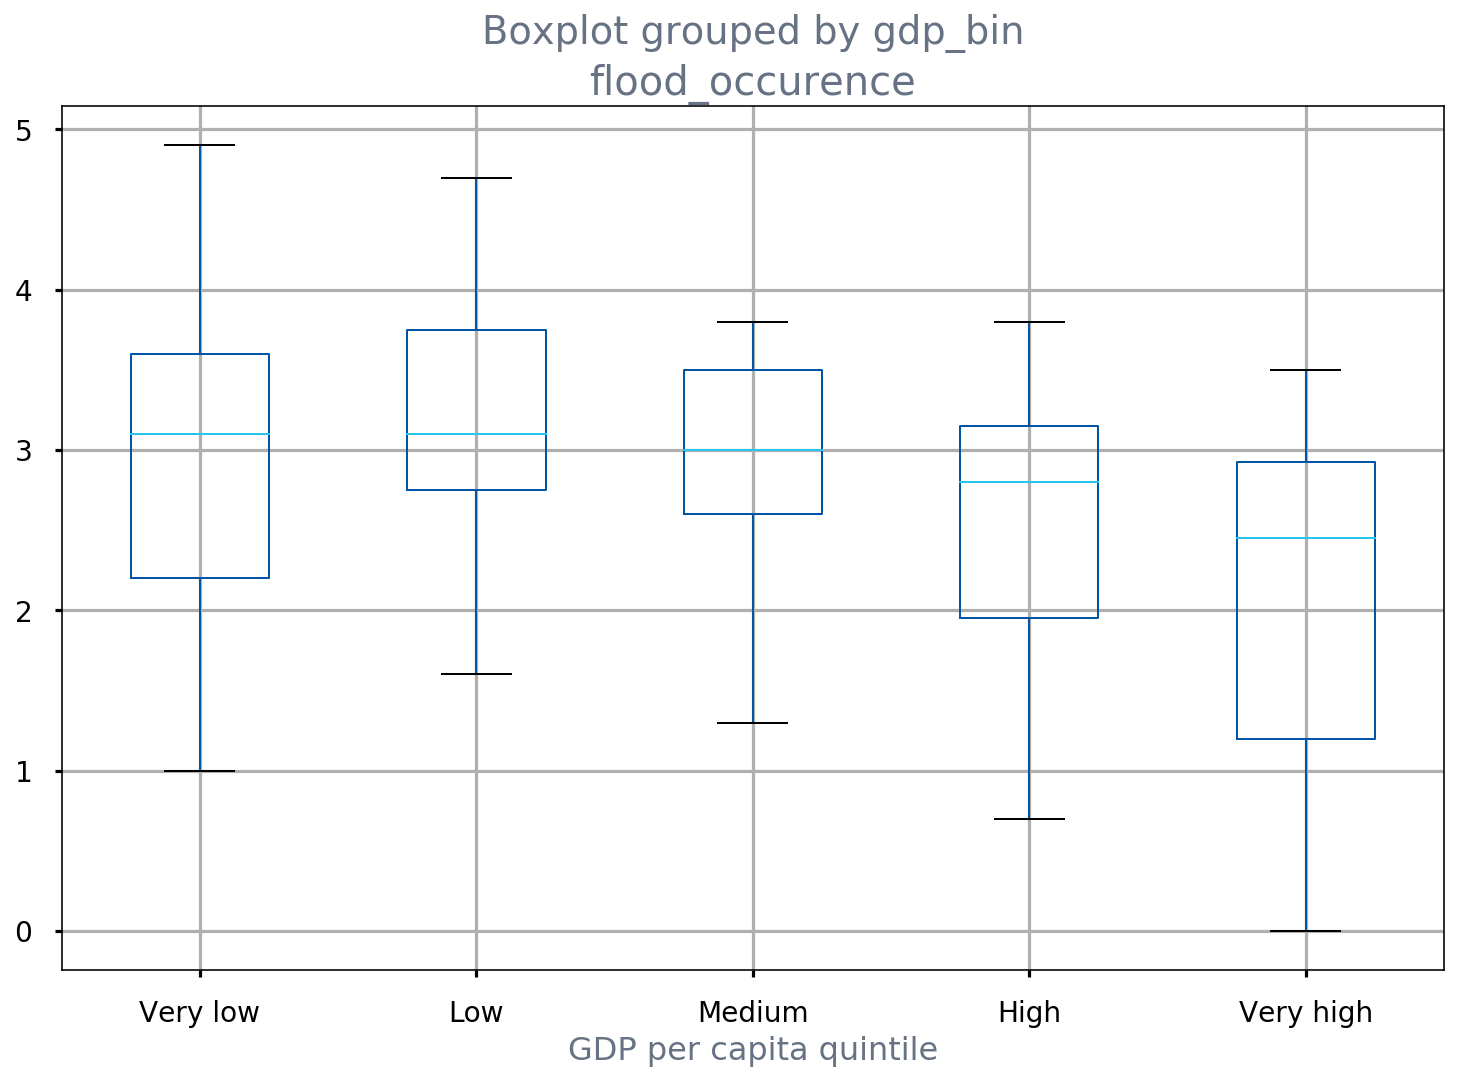

In [19]:
mult_boxplots(recent, 'flood_occurence', 'gdp_bin',
             xlabel='GDP per capita quintile')